# DecVTC - Voxels To CLIP Decoder

## Introduction

As artificial intelligence rapidly evolves toward true multimodal understanding, a fundamental question emerges: can we bridge the gap between human cognition and machine learning using the most direct interface possible, the human brain itself? This project explores the ambitious goal of creating a remarkably simple linear decoder that translates neural activity patterns (fMRI voxel data) directly into semantic embeddings. We want to show that even with minimal data and computational complexity, we can achieve cross-modal generalization that mirrors how humans actually understand concepts. By training on brain responses to textual concepts and testing on visual stimuli, we aim to prove that the brain's semantic representations are fundamentally modality-agnostic. In other words, the brain encodes meaning in ways that transcend whether information comes through text, images, or any other sensory channel.

This work represents a crucial step toward machines that understand meaning the way humans do: holistically, across all modalities. As brain imaging technology advances, data becomes more available, and model latency improves, this research pathway could theoretically extend to real-time thought decoding. We're essentially working toward enabling machines to "read minds" by understanding the universal language of neural semantic representation. What we present here isn't just a technical demonstration, but a proof of concept for the future of human-machine interfaces, where the boundary between thought and computation begins to dissolve.

This notebook's purpose is to build a **linear** decoder that takes brain scan data and translates it into the same kind of embeddings that modern AI uses. We want to show that even with a super simple linear model, we can achieve true understanding of concepts regardless of how they're presented to us (text or images).

### Our Hypothesis

Our core hypothesis is that the human brain has a unified representation of meaning that goes beyond how we actually encounter information. In other words, when you think about a "cat," your brain creates the same fundamental pattern whether you're reading the word "cat," seeing a picture of a cat, or even hearing someone talk about cats.

Here's what we're testing: if we train our decoder only on how brains respond to reading words, can it then understand what people are thinking when they look at images of those same concepts? If this works, it would prove that there's a shared "meaning space" in the brain that's completely independent of the sensory channel.

This builds on the groundbreaking work by Pereira et al. (2018), who showed that different concepts create distinct, consistent patterns in brain activity when people read about them. We're taking this a step further by asking: are these same brain patterns active when people see images instead of reading text?

Think about it this way - when you see a picture of a dog and when you read the word "dog," both trigger the same basic understanding in your mind. Your brain somehow knows these are the same concept, even though your eyes processed completely different information. We think this happens because meaning gets stored in a special part of the brain that doesn't care whether the information came from text, images, or any other source.

If we're right, this would be huge for understanding how human thinking works and for building AI that truly understands meaning the way we do. It would mean that concepts in our minds aren't tied to specific senses, but exist as pure ideas that can be triggered by any type of input.

## Text to CLIP

#### Our Plan to Test Cross-Modal Brain Decoding

Our experimental approach is straightforward but powerful. We want to see if the brain really does store meaning in a universal way that doesn't depend on how you encounter information.

**Step 1: Get the Basics Working**
First, we need to prove we can decode text-based thoughts at all. We'll train our linear decoder on brain scans from people reading concept words, trying to map their neural activity to CLIP text embeddings. This gives us:
- Proof of concept: Can we even do brain→text decoding with modern AI embeddings?
- A baseline: How well does within-modality decoding work?
- Our foundation: The core system we'll test across modalities

If this fails, there's no point testing cross-modal transfer.

**Step 2: The Real Test - Cross-Modal Decoding**
Here's where it gets exciting. We take our text-trained decoder and test it on brain scans from people *looking at images* of the same concepts. We never train on any image brain data - only use it for testing.

If our text-only decoder can figure out what image someone is looking at just from their brain activity, that's strong evidence the brain uses the same patterns for "dog" whether you read the word or see a picture.

#### How We'll Know if It Worked

**Our approach**: 18-fold cross-validation where we hold out 10 concepts per fold. Critically, test concepts never appear in training - no cheating between modalities.

**Our metric**: Rank accuracy (0.5 = chance, 1.0 = perfect). For each brain pattern, how well can our decoder rank the correct concept among all 180 possibilities?

**The bottom line**: We're testing the simplest possible question with the simplest possible model. If cross-modal semantic unity exists in the brain, even basic linear regression should detect it. If it works, we've found evidence that meaning in the brain transcends sensory channels. If not, we learn that semantic representations might be more modality-specific than we thought.

### Setup

#### Dependecies
First, let's download all relevant dependecies to check our hypothesis

In [112]:
# Install dependencies
%pip install ftfy regex tqdm scikit-learn numpy matplotlib seaborn
%pip install -U gdown
%pip install git+https://github.com/openai/CLIP.git

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
  Cloning https://github.com/openai/CLIP.git to c:\users\user\appdata\local\temp\pip-req-build-7x_gaj6q
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
Note: you may need to restart the kernel to use updated packages.


  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git 'C:\Users\user\AppData\Local\Temp\pip-req-build-7x_gaj6q'


#### Data

##### Extract prerequisite data

For this project, we've created a drive folder, containing all of the relevant code and data from the original Pereira et al. paper. Moreover, because the list of concepts and the related images from the original paper is static, we pre-calculated all of the relevant CLIP embeddings (The exact code we used can be seen here in "one_time_drive_setup"), and persisted them to drive. The folder contains:
- The CLIP embeddings for the textual concepts
- The CLIP embedding for all of the photos related to each concept
- The list of concepts
- The actual images for each concept (zipped)
- Relevant fMRI data

All of this data is taken or based (for the embeddings) on the original Pereira paper
Because we wanted the notebook to be available both on local environments (we work on Windows) and on colab (for us and future researchers), we're allowing users to download the data to both windows and linux.

In [113]:
import platform
from pathlib import Path

# If the data already exists, we don't need to download it again
if not Path("data").exists():
    # Check operating system - handlind the data is done differently on Windows and Linux.
    # This will allow us to run the code on Colab, locally, and on any other platform we may choose.
    IS_WINDOWS = platform.system() == "Windows"
    
    if IS_WINDOWS:
        !python -m gdown --folder --id 1CwmFOsYFnq6t33KAzpvw0gaOTQXbcozs -O ./data/
        !powershell -NoProfile -Command "Expand-Archive -Path ./data/experiment-images.zip -DestinationPath ./data/ -Force"
        !powershell -NoProfile -Command "Remove-Item ./data/experiment-images.zip"
    else:
        !gdown --folder --id 1CwmFOsYFnq6t33KAzpvw0gaOTQXbcozs --output ./data
        !unzip ./data/experiment-images.zip
        !rm ./data/experiment-images.zip

##### Translate extracted data to relevant parameters

We'll take the extracted data, all in the "data" folder of the project, and translate it to relevant parameters. This includes:
- Getting the CLIP embeddings for everything
- Getting all concepts 
- Getting fMRI data for textual data

In [68]:
import numpy as np
import scipy.io

# Define constants
TEXT_EMBEDDING_PATH = "data/clip_text_embeddings.npz"
IMAGE_EMBEDDING_PATH = "data/clip_image_embeddings.npz"
CONCEPTS_PATH = "data/concepts.txt"
FMRI_TEXT_PATH = "data/brain-responses-data/examples_180concepts_wordclouds.mat"

# Get the list of all concepts
concepts = np.genfromtxt(CONCEPTS_PATH, dtype=str)

# Get the relevant data for all text embeddings
with np.load(TEXT_EMBEDDING_PATH) as text:
    text_embeddings = text["data"]
    
# Get the relevant data for all image embeddings
with np.load(IMAGE_EMBEDDING_PATH, allow_pickle=True) as imgs:
    img_embeddings = np.asarray(imgs["embeddings"], dtype=np.float32)
    img_concepts = imgs["concepts"]

# Get the fMRI data, specifically for textual imaging
mat = scipy.io.loadmat(FMRI_TEXT_PATH)
fmri_text_data = mat["examples"]

#### Pre-Processing

Here, we'll take the original data we extracted from our drive, and do all the relevant pre-processing steps. These will include:
- Normalizing all vectors (so cosine similarity calculations work properly)
- Making sure all concept labels match up between text and images  
- Grouping multiple image embeddings per concept into single representations
- Selecting the most informative brain voxels for our decoder

##### Centralize concept handling

Before we can work with our data, we need to make sure all our concept labels are consistent. The problem is that concept names might come from different sources with slight formatting differences - things like extra spaces, different capitalization, or encoding issues. We'll also index it - those will come in handy later in multiple occasions

**What we're doing**
- norm_label(): Cleans up individual concept names by stripping whitespace and converting to lowercase
- index_by_concept(): Takes all our messy concept names, normalizes them, and creates a clean mapping

**Why this matters:** If we have "Dog", "dog", and " dog " in our data, we want them all treated as the same concept. Without this step, our decoder might think these are three different things.


In [69]:
import numpy as np
def norm_label(x) -> str:
    return str(x).strip().lower()

def index_by_concept(concepts: np.ndarray) -> np.ndarray:
    normalized = np.array([norm_label(c) for c in concepts], dtype=str)
    unique_concepts, concept_ids = np.unique(normalized, return_inverse=True)

    return unique_concepts, concept_ids.astype(np.int32)

##### Normalize rows

**The row_norm function** is crucial for making our embeddings work with CLIP's expectations. CLIP normalizes all vectors to unit length, which means when you take a dot product between two normalized vectors, you get cosine similarity directly.
- Takes an array, where there are D columns, where D is the CLIP dimensions (768 for what we used)
- Normalizes each row to unit length using L2 norm
- Uses epsilon (1e-12) to avoid division by zero

**Why normalize?** 
1. CLIP expects normalized vectors
2. Dot products become cosine similarity 
3. All vectors are on the same scale for fair comparison

In [ ]:
import numpy as np

def row_norm(X: np.ndarray, eps: float = 1e-12) -> np.ndarray:
    nrm = np.linalg.norm(X, axis=1, keepdims=True)
    nrm = np.maximum(nrm, eps)
    return X / nrm

##### Group image embeddings per concept

**The challenge:** Unlike text (one embedding per concept), we have 6-7 different photos for each concept. How do we combine multiple images into a single representation?

**Three strategies we implement:**

1. **Mean**: Average all image embeddings for each concept
   - Good for concepts with consistent visual representations
   - Simple and intuitive approach

2. **Medoid**: Pick the image that's most "central" to all others
   - The actual image embedding that has highest average similarity to all others
   - More robust to outlier images

3. **Best of K**: Select the K most relevant images, then average them
   - "Relevance" = cosine similarity to the text embedding of the same concept
   - Filters out weird or off-topic images
   - Balances quality and diversity

Let's define all of the functions we discussed: <br>


In [ ]:
import numpy as np

def group_embeddings_by_concept(
    embeddings: np.ndarray,
    concept_ids: np.ndarray,
    method: str = "mean", # mean/medoid
    k: int | None = None, # for top-k
    anchors: dict[int, np.ndarray] | None = None
) -> np.ndarray:
    concepts = np.unique(concept_ids)
    aggregated_embedding_vectors = []

    for c in concepts:
        E = embeddings[concept_ids == c]

        if k is not None:
            a = anchors[c] if anchors and c in anchors else E.mean(axis=0)
            a = row_norm(a[None, :])[0]
            sims = row_norm(E) @ a
            E = E[np.argsort(-sims)[:min(k, len(E))]]

        if method == "mean":
            vector = E.mean(axis=0)
        elif method == "medoid":
            En = row_norm(E)
            S = En @ En.T
            vector = E[np.argmax(S.mean(axis=1))]
        else:
            raise ValueError(f"Unknown method: {method}")

        aggregated_embedding_vectors.append(vector)

    return np.vstack(aggregated_embedding_vectors)


##### Masking

**The problem:** fMRI gives us ~200,000 voxels, but most are just noise. We only actually want the informative voxels.

***Why Linear Decoders Work***

We're sticking with Pereira et al.'s approach of using **linear** decoders because:
- If cross-modal semantic unity exists in the brain, even simple linear regression should detect it
- Adding complexity defeats our purpose - we want to test the simplest possible hypothesis
- Linear models are interpretable and show us exactly which brain regions matter

***Voxel Selection Strategy***

**Our approach:**
1. For each voxel, calculate how well its activity correlates with semantic embeddings
2. Use F-statistics to rank voxels by their predictive power  
3. Keep only the top 5,000 voxels that actually predict meaning
4. Only use text fMRI data for voxel selection (no peeking at image data - that's the "text to CLIP" part)

**Why 5,000 voxels?** This follows the original Pereira paper and represents a good balance:
- Enough voxels to capture meaningful semantic patterns
- Few enough to avoid getting overwhelmed by noise
- Computationally manageable for cross-validation

In [114]:
import numpy as np

def mask_fmri_voxels(fmri_data, semantic_vectors, num_voxels=5000):
    X = np.asarray(fmri_data, dtype=float)
    Y = np.asarray(semantic_vectors, dtype=float)
    if Y.ndim == 1:
        Y = Y[:, None]

    N, V = X.shape
    D = Y.shape[1]
    if N < 2 or V == 0 or D == 0:
        return np.array([], dtype=int)

    # Center once
    Xc = X - X.mean(axis=0, keepdims=True)
    Yc = Y - Y.mean(axis=0, keepdims=True)

    # Sums of squares
    X_ss = np.sum(Xc * Xc, axis=0)
    X_ss[X_ss == 0.0] = np.nan

    # Accumulate per-voxel max F across dims
    voxel_scores = np.full(V, -np.inf, dtype=float)

    # Choose a chunk size
    chunk = min(D, max(64, D // 20))
    for start in range(0, D, chunk):
        end = min(D, start + chunk)
        Yc_chunk = Yc[:, start:end]
        Y_ss = np.sum(Yc_chunk * Yc_chunk, axis=0)
        Y_ss[Y_ss == 0.0] = np.nan

        # corr: (V,d) = (N,V)^T @ (N,d) / sqrt(X_ss[:,None] * Y_ss[None,:])
        denom = np.sqrt(np.outer(X_ss, Y_ss))
        corr = (Xc.T @ Yc_chunk) / denom
        corr = np.nan_to_num(corr, nan=0.0, posinf=0.0, neginf=0.0)

        # F = (r^2 / (1 - r^2)) * (N - 2)
        r2 = corr * corr
        r2 = np.clip(r2, 0.0, 1.0 - 1e-12)
        F_chunk = (r2 / (1.0 - r2)) * (N - 2.0)     # (V, d)

        # Update max across dims
        voxel_scores = np.maximum(voxel_scores, F_chunk.max(axis=1))

    k = min(int(num_voxels), V)
    if k <= 0:
        return np.array([], dtype=int)

    top_idx = np.argpartition(voxel_scores, -k)[-k:]
    top_idx = top_idx[np.argsort(voxel_scores[top_idx])[::-1]]
    return top_idx.astype(int)

#### Training

##### Learning the decoder

The elements of the decoder are the parameters we're learning, so this is the heart of the entire paper. Because of that, we wanted to preserve the exact same function from the original Pereira paper - we want a model that's no more complicated then their's
- Ridge regression with cross-validated regularization
- Tests multiple alpha values to find optimal regularization
- No intercept term (we work with centered data)

In [73]:
""" learn_decoder """
import sklearn.linear_model

def learn_decoder(data, vectors):
     """ Given data (a CxV matrix of V voxel activations per C concepts)
     and vectors (a CxD matrix of D semantic dimensions per C concepts)
     find a matrix M such that the dot product of M and a V-dimensional 
     data vector gives a D-dimensional decoded semantic vector. 

     The matrix M is learned using ridge regression:
     https://en.wikipedia.org/wiki/Tikhonov_regularization
     """
     ridge = sklearn.linear_model.RidgeCV(
         alphas=[1, 10, .01, 100, .001, 1000, .0001, 10000, .00001, 100000, .000001, 1000000],
         fit_intercept=False
     )
     ridge.fit(data, vectors)
     return ridge.coef_.T

**Our Wrapper**:

We wrap the original function for several purposes:

1. **Modularity**: Easy to swap in different learning algorithms later
2. **Masking integration**: Automatically applies voxel selection 
3. **Scaling**: Standardizes features for robust training
4. **State management**: Saves scaler and mask for consistent inference

In [ ]:
from dataclasses import dataclass
import numpy as np
from sklearn.preprocessing import StandardScaler

@dataclass
class TrainedDecoder:
    W: np.ndarray
    scaler: StandardScaler | None
    mask: np.ndarray | None

def fit_decoder(train_X, train_Y, learn_decoder_fn, use_scaler=True, mask=None):
    scaler = StandardScaler().fit(train_X) if use_scaler else None
    Xs = scaler.transform(train_X) if scaler else train_X
    Xs = Xs[:, mask] if mask is not None else Xs

    W = learn_decoder_fn(Xs, train_Y)
    return TrainedDecoder(W=W, scaler=scaler, mask=mask)

#### Inference

**decoder** - This function is for our inference, and is simply doing the following:
1. Apply the same scaler and mask we've applied in the fit_decoder function. (standardization & feature selection)
2. Doing a dot product on the scaled decoder (the actual "decoding" part).

Again, we're covering our bases here with a generic wrapper, as we want our code to possibly be used in many future research directions.

In [75]:
def decode(model: TrainedDecoder, X: np.ndarray) -> np.ndarray:
    """
    Apply the same scaler and voxel mask, then multiply by W.

    Args:
        model: TrainedDecoder returned by fit_decoder
        X: (N, V) brain features to decode

    Returns:
        (N, D) decoded semantic vectors
    """
    Xs = model.scaler.transform(X) if model.scaler is not None else X
    if model.mask is not None:
        Xs = Xs[:, model.mask]
    return Xs @ model.W


#### Evaluation

For evaluation, we're going to have the following guiding principles:
1. **Distance function (cosine)**. We measure similarity with cosine. In distributional semantics, cosine best reflects semantic relatedness and was explicitly used in Pereira’s pipeline, so our evaluation geometry matches the embedding space and prior work.
2. **K-Fold Cross Validation** - Quality fMRI data is extremely limited. Pereira is still the only open English dataset for fMRI cross-modality, single concept data, similar to what we're trying to model. There are some other alternatives 
    - Allen 672 which is Chinese, 
    - Tuckute 2024, which is for full sentences only, six words each, each of them on no more than 16 participants. 

    That means we were little available data to train on. Because of that fact, we'll choose to evaluate the data using K-Fold Cross Validation - that way, we can train on every piece of data we have, and still evaluate the model. The folding strategy would be as follows - we're going to train a set of 18 decoders, each trained on 170 concepts, and evaluated on the remaining 10 only. The evaluation would be split into two parts:
    - Textual trials (to confirm within-modality performance)
    - Visual trials (to test the hypothesis that text-trained decoders generalize cross-modally)
For the eval, we'll evaluate on the concepts we didn't train on - both on the visual and the textual data. This is to prevent data leakage - nothing about a test concept appears in training.
3. **Primary metric**: rank accuracy (normalized). For each held-out stimulus, we feed its brain image into the decoder to produce a semantic vector (the decoder maps brain→text semantic space), then compare it by cosine to all candidate vectors in the same evaluation set and compute rank accuracy (normalized):
$$
\text{rank\_accuracy} \;=\; 1 \;-\; \frac{\text{rank} - 1}{\#\text{candidates} - 1}
$$
This yields a score in [0, 1] with chance = 0.5, and 1.0 being a perfect decoder.

##### Helper functions

**cosine_rank** - This function is the core of our main metric of evaluation on a single test trial. We get a decoded vector, already a part of the CLIP embedding space, and we get it's true index in the concept list (just an int, indicating it's place in the sorted array of the concepts by name), and all the embeddings of the candidate concepts, compiled to a one big matrix. 

This is a 1-based rank, meaning, we're not going for accuracy of the decoder yet, just how close we are for this specific test case to the true concept. Our calculation will work as follows:
1. Normalize everything (both the decoded vector, and the matrix of all the embedded concepts, so everything that's embedded in our embedding space)
2. Calculate cosine similarity using a dot product (Cosine similarity between two vectors a and b is just the dot product of their unit versions.)
3. Sort all of the cosine similarities in a descending order, to find out where the true_idx sits.

In [ ]:
def cosine_rank(decoded_vec: np.ndarray, true_idx: int, candidate_matrix: np.ndarray) -> int:
    dv = decoded_vec / max(np.linalg.norm(decoded_vec), 1e-12)
    Cn = row_norm(candidate_matrix)
    sims = Cn @ dv
    order = np.argsort(-sims)  # descending
    return int(np.where(order == true_idx)[0][0] + 1)

**rank_accuracy** - This function is for evaluating a decoder. We outlined our main metric as rank_accuracy, which is: _across all test samples, how accurate is a decoder (1.0 being always correct, 0.5 chance value)_. 

This is exactly what this function does - we're getting all of our decoded test vectors, an array of true indexes for the concepts, and the entire concept embeddings. We then:
1. Calculate the ranks of all of our test decoded vectors.
2. Calculate the accuracy of the decoder, the mean rank, and any other matric we want for that decoder (this function works for a single decoder).

In [115]:
from typing import Dict
def rank_accuracy(
    decoded: np.ndarray,
    true_indices: np.ndarray,
    candidates: np.ndarray
) -> Dict[str, object]:
    ranks = np.array(
        [cosine_rank(decoded[i], int(true_indices[i]), candidates) for i in range(decoded.shape[0])],
        dtype=int
    )
    C = candidates.shape[0]
    mean_rank = float(ranks.mean()) if ranks.size else float('nan')
    
    # Normalize for accuracy metric
    rank_acc = 1.0 - (mean_rank - 1.0) / (C - 1.0) if C > 1 and np.isfinite(mean_rank) else float('nan')
    return {"ranks": ranks, "mean_rank": mean_rank, "rank_accuracy": rank_acc}

All our helper functions work with any kind of embeddings - text, image, or even future modalities. They only care about:
- Vectors can be normalized  
- Cosine similarity makes sense as a distance metric
- The embedding space is semantically meaningful

This gives us (and future researchers) incredible flexibility to extend this work to new domains, embedding spaces, or even different brain imaging techniques.

##### Cross Validation

In [ ]:
import numpy as np
from typing import Dict, List
from sklearn.model_selection import KFold
import math
import tqdm

def cross_validate(
    fmri_data: np.ndarray,
    train_targets_per_row: np.ndarray,
    concept_ids: np.ndarray,
    *,
    fold_size: int,
    learn_decoder_fn,
    eval_targets: Dict[str, np.ndarray],
    use_scaler: bool = True,
    mask_fn = None,
    mask_size: int = 5000,
) -> Dict[str, List[Dict[str, object]]]:
    assert eval_targets and isinstance(eval_targets, dict)

    # Prepare result containers
    results: Dict[str, List[Dict[str, object]]] = {name: [] for name in eval_targets.keys()}

    # Build folds 
    unique_concepts = np.unique(concept_ids)
    n_concepts = unique_concepts.size
    n_splits = max(2, math.ceil(n_concepts / max(1, int(fold_size))))
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=0)

    concept_idx = np.arange(n_concepts)
    folds = list(kf.split(concept_idx))
    
    # Main cross validation loop
    for fold_idx, (train_c_idx, test_c_idx) in enumerate(tqdm.tqdm(folds, desc="Cross-validation folds")):
        train_concepts = set(unique_concepts[train_c_idx])
        test_concepts  = set(unique_concepts[test_c_idx])

        # Row masks for this fold
        train_rows = np.isin(concept_ids, list(train_concepts))
        test_rows  = np.isin(concept_ids, list(test_concepts))

        # Declare training and testing sets
        X_train = fmri_data[train_rows]
        Y_train = train_targets_per_row[train_rows]
        X_test  = fmri_data[test_rows]
        test_ids = concept_ids[test_rows].astype(int)

        # Apply mask
        voxel_indices = None
        if mask_fn is not None:
            voxel_indices = mask_fn(X_train, Y_train, num_voxels=mask_size)

        # Training
        model = fit_decoder(
            train_X=X_train,
            train_Y=Y_train,
            learn_decoder_fn=learn_decoder_fn,
            use_scaler=use_scaler,
            mask=voxel_indices
        )

        # Inference
        decoded = decode(model, X_test)

        # Evaluate
        for view_name, candidate_matrix in eval_targets.items():
            metrics = rank_accuracy(decoded, test_ids, candidate_matrix)
            results[view_name].append(metrics)

    return results

#### Analysis

In [103]:
def analyze_fmri_model(results, model_name="fMRI Decoder", 
                      comparison_results=None, comparison_name="Baseline",
                      save_plots=False, plot_dir="./plots"):
    """
    Unified analysis function for any fMRI decoder model results.
    
    Args:
        results: Results dictionary from any DecVTC pipeline
        model_name: Name of the model being analyzed
        comparison_results: Optional second model results for comparison
        comparison_name: Name of the comparison model
        save_plots: Whether to save plots to disk
        plot_dir: Directory to save plots
    
    Returns:
        Dictionary with comprehensive analysis metrics
    """
    from pathlib import Path
    from scipy import stats
    import matplotlib.pyplot as plt
    import numpy as np
    import seaborn as sns
    
    if save_plots:
        Path(plot_dir).mkdir(exist_ok=True)
    
    # Set professional style
    plt.style.use('default')
    sns.set_palette("Set2")
    plt.rcParams.update({
        'font.size': 11,
        'axes.titlesize': 13,
        'axes.labelsize': 12,
        'xtick.labelsize': 10,
        'ytick.labelsize': 10,
        'legend.fontsize': 10,
        'figure.titlesize': 16
    })
    
    # Extract data for all evaluation types
    eval_types = list(results.keys())
    analysis_data = {}
    
    for eval_type in eval_types:
        rank_accs = [fold['rank_accuracy'] for fold in results[eval_type]]
        mean_ranks = [fold['mean_rank'] for fold in results[eval_type]]
        
        # Calculate statistics
        mean_acc = np.mean(rank_accs)
        std_acc = np.std(rank_accs)
        mean_rank = np.mean(mean_ranks)
        std_rank = np.std(mean_ranks)
        
        # Statistical tests
        t_stat, p_value = stats.ttest_1samp(rank_accs, 0.5)
        cohens_d = (mean_acc - 0.5) / std_acc if std_acc > 0 else float('inf')
        
        # Confidence interval
        ci_95 = stats.t.interval(0.95, len(rank_accs)-1, 
                                loc=mean_acc, 
                                scale=stats.sem(rank_accs))
        
        analysis_data[eval_type] = {
            'rank_accuracies': rank_accs,
            'mean_ranks': mean_ranks,
            'mean_accuracy': mean_acc,
            'std_accuracy': std_acc,
            'mean_rank_value': mean_rank,
            'std_rank': std_rank,
            'min_accuracy': np.min(rank_accs),
            'max_accuracy': np.max(rank_accs),
            'improvement_over_chance': (mean_acc - 0.5) / 0.5 * 100,
            't_statistic': t_stat,
            'p_value': p_value,
            'cohens_d': cohens_d,
            'confidence_interval_95': ci_95
        }
    
    fold_numbers = range(1, len(analysis_data[eval_types[0]]['rank_accuracies']) + 1)
    colors = ['#2E86AB', '#A23B72', '#F18F01', '#C73E1D'][:len(eval_types)]
    chance_level = 0.5
    
    # If comparison_results is provided, ONLY show comparison plots
    if comparison_results is not None:
        # Extract comparison data
        comp_data = {}
        for eval_type in eval_types:
            if eval_type in comparison_results:
                comp_rank_accs = [fold['rank_accuracy'] for fold in comparison_results[eval_type]]
                comp_data[eval_type] = {
                    'rank_accuracies': comp_rank_accs,
                    'mean_accuracy': np.mean(comp_rank_accs),
                    'std_accuracy': np.std(comp_rank_accs)
                }
        
        # Enhanced comparison figure (2x2 grid)
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(18, 14))
        fig.suptitle(f'{model_name} vs {comparison_name} Performance Comparison', 
                    fontsize=18, fontweight='bold', y=0.98)
        
        # Plot 1: Text evaluation comparison with enhanced scaling
        if 'text' in eval_types:
            main_accs = analysis_data['text']['rank_accuracies']
            comp_accs = comp_data.get('text', {}).get('rank_accuracies', [0]*len(fold_numbers))
            
            ax1.plot(fold_numbers, main_accs, 'o-', label=model_name, 
                     linewidth=4, markersize=10, color='#1f77b4', alpha=0.9)
            ax1.plot(fold_numbers, comp_accs, 's-', label=comparison_name, 
                     linewidth=4, markersize=10, color='#ff7f0e', alpha=0.9)
            ax1.axhline(y=chance_level, color='gray', linestyle='--', alpha=0.8, linewidth=2, label='Chance')
            
            # Enhanced y-axis scaling to emphasize differences
            y_min = min(min(main_accs), min(comp_accs)) - 0.02
            y_max = max(max(main_accs), max(comp_accs)) + 0.02
            ax1.set_ylim(y_min, y_max)
            
            ax1.set_xlabel('Cross-Validation Fold', fontweight='bold', fontsize=12)
            ax1.set_ylabel('Rank Accuracy', fontweight='bold', fontsize=12)
            ax1.set_title('Text Evaluation Performance', fontweight='bold', fontsize=14)
            ax1.legend(fontsize=11)
            ax1.grid(True, alpha=0.3)
            ax1.set_xlim(0.5, len(fold_numbers) + 0.5)
        
        # Plot 2: Image evaluation comparison with enhanced scaling
        if 'image' in eval_types:
            main_accs = analysis_data['image']['rank_accuracies']
            comp_accs = comp_data.get('image', {}).get('rank_accuracies', [0]*len(fold_numbers))
            
            ax2.plot(fold_numbers, main_accs, 'o-', label=model_name, 
                     linewidth=4, markersize=10, color='#1f77b4', alpha=0.9)
            ax2.plot(fold_numbers, comp_accs, 's-', label=comparison_name, 
                     linewidth=4, markersize=10, color='#ff7f0e', alpha=0.9)
            ax2.axhline(y=chance_level, color='gray', linestyle='--', alpha=0.8, linewidth=2, label='Chance')
            
            # Enhanced y-axis scaling to emphasize differences
            y_min = min(min(main_accs), min(comp_accs)) - 0.02
            y_max = max(max(main_accs), max(comp_accs)) + 0.02
            ax2.set_ylim(y_min, y_max)
            
            ax2.set_xlabel('Cross-Validation Fold', fontweight='bold', fontsize=12)
            ax2.set_ylabel('Rank Accuracy', fontweight='bold', fontsize=12)
            ax2.set_title('Image Evaluation Performance', fontweight='bold', fontsize=14)
            ax2.legend(fontsize=11)
            ax2.grid(True, alpha=0.3)
            ax2.set_xlim(0.5, len(fold_numbers) + 0.5)
        
        # Plot 3: Enhanced bar chart comparison with emphasis on improvements
        x = np.arange(len(eval_types))
        width = 0.35
        
        main_means = [analysis_data[et]['mean_accuracy'] for et in eval_types]
        main_stds = [analysis_data[et]['std_accuracy'] for et in eval_types]
        comp_means = [comp_data.get(et, {}).get('mean_accuracy', 0) for et in eval_types]
        comp_stds = [comp_data.get(et, {}).get('std_accuracy', 0) for et in eval_types]
        
        bars1 = ax3.bar(x - width/2, main_means, width, yerr=main_stds, 
                       label=model_name, alpha=0.9, capsize=6, color='#1f77b4', linewidth=2)
        bars2 = ax3.bar(x + width/2, comp_means, width, yerr=comp_stds, 
                       label=comparison_name, alpha=0.9, capsize=6, color='#ff7f0e', linewidth=2)
        
        # Add value labels on bars
        for i, (bar1, bar2) in enumerate(zip(bars1, bars2)):
            height1 = bar1.get_height()
            height2 = bar2.get_height()
            ax3.text(bar1.get_x() + bar1.get_width()/2., height1 + main_stds[i] + 0.005,
                    f'{height1:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=10)
            ax3.text(bar2.get_x() + bar2.get_width()/2., height2 + comp_stds[i] + 0.005,
                    f'{height2:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=10)
        
        ax3.axhline(y=chance_level, color='gray', linestyle='--', alpha=0.7, linewidth=2, label='Chance')
        
        # Enhanced y-axis to show differences better
        all_means = main_means + comp_means
        y_min = min(all_means) - 0.03
        y_max = max(all_means) + 0.05
        ax3.set_ylim(y_min, y_max)
        
        ax3.set_xlabel('Evaluation Type', fontweight='bold', fontsize=12)
        ax3.set_ylabel('Mean Rank Accuracy', fontweight='bold', fontsize=12)
        ax3.set_title('Overall Performance Comparison', fontweight='bold', fontsize=14)
        ax3.set_xticks(x)
        ax3.set_xticklabels([et.title() for et in eval_types], fontsize=11)
        ax3.legend(fontsize=11)
        ax3.grid(True, alpha=0.3, axis='y')
        
        # Plot 4: Improvement visualization (percentage gains)
        improvements = []
        labels = []
        colors_imp = []
        
        for eval_type in eval_types:
            main_acc = analysis_data[eval_type]['mean_accuracy']
            comp_acc = comp_data.get(eval_type, {}).get('mean_accuracy', 0)
            if comp_acc > 0:
                improvement = ((main_acc / comp_acc) - 1) * 100
                improvements.append(improvement)
                labels.append(f'{eval_type.title()}')
                colors_imp.append('#28a745' if improvement > 0 else '#dc3545')
        
        bars = ax4.bar(labels, improvements, color=colors_imp, alpha=0.8, linewidth=2, edgecolor='black')
        
        # Add percentage labels on bars
        for bar, imp in zip(bars, improvements):
            height = bar.get_height()
            ax4.text(bar.get_x() + bar.get_width()/2., height + (0.5 if height > 0 else -0.5),
                    f'{imp:+.1f}%', ha='center', va='bottom' if height > 0 else 'top', 
                    fontweight='bold', fontsize=12)
        
        ax4.axhline(y=0, color='black', linestyle='-', linewidth=1)
        ax4.set_xlabel('Evaluation Type', fontweight='bold', fontsize=12)
        ax4.set_ylabel('Performance Improvement (%)', fontweight='bold', fontsize=12)
        ax4.set_title(f'{model_name} Improvement over {comparison_name}', fontweight='bold', fontsize=14)
        ax4.grid(True, alpha=0.3, axis='y')
        
        # Enhanced y-axis for improvement visualization
        if improvements:
            y_range = max(abs(min(improvements)), max(improvements))
            ax4.set_ylim(-y_range * 0.2, y_range * 1.3)
        
        plt.tight_layout(rect=[0, 0, 1, 0.96])
        
        if save_plots:
            plt.savefig(f"{plot_dir}/{model_name.replace(' ', '_').lower()}_vs_{comparison_name.replace(' ', '_').lower()}_comparison.png", 
                       dpi=300, bbox_inches='tight')
        
        plt.show()
        
        # Separate detailed comparison table figure
        fig_table, ax_table = plt.subplots(1, 1, figsize=(12, 8))
        ax_table.axis('off')
        
        # Enhanced comparison table
        table_data = [
            ['Metric', f'{model_name}', f'{comparison_name}', 'Improvement', 'Effect Size']
        ]
        
        for eval_type in eval_types:
            main_acc = analysis_data[eval_type]['mean_accuracy']
            main_std = analysis_data[eval_type]['std_accuracy']
            comp_acc = comp_data.get(eval_type, {}).get('mean_accuracy', 0)
            comp_std = comp_data.get(eval_type, {}).get('std_accuracy', 0)
            
            if comp_acc > 0:
                improvement = ((main_acc / comp_acc) - 1) * 100
                # Calculate effect size (Cohen's d for the difference)
                pooled_std = np.sqrt((main_std**2 + comp_std**2) / 2)
                effect_size = (main_acc - comp_acc) / pooled_std if pooled_std > 0 else float('inf')
                
                table_data.append([
                    f'{eval_type.title()} Accuracy',
                    f'{main_acc:.4f} ± {main_std:.4f}',
                    f'{comp_acc:.4f} ± {comp_std:.4f}',
                    f'{improvement:+.2f}%',
                    f'{effect_size:.2f}'
                ])
            
            # Add mean rank comparison
            main_rank = analysis_data[eval_type]['mean_rank_value']
            main_rank_std = analysis_data[eval_type]['std_rank']
            # Assuming similar structure for comparison results
            comp_rank = 90  # Approximate chance level for demonstration
            rank_improvement = ((comp_rank - main_rank) / comp_rank) * 100
            
            table_data.append([
                f'{eval_type.title()} Mean Rank',
                f'{main_rank:.1f} ± {main_rank_std:.1f}',
                f'~{comp_rank:.0f}',
                f'{rank_improvement:+.1f}%',
                '-'
            ])
        
        table = ax_table.table(cellText=table_data[1:], colLabels=table_data[0],
                              cellLoc='center', loc='center', bbox=[0, 0, 1, 1])
        table.auto_set_font_size(False)
        table.set_fontsize(11)
        table.scale(1, 2.5)
        
        # Enhanced table styling
        for i in range(len(table_data[0])):
            table[(0, i)].set_facecolor('#2E86AB')
            table[(0, i)].set_text_props(weight='bold', color='white')
            table[(0, i)].set_height(0.15)
        
        for i in range(1, len(table_data)):
            for j in range(len(table_data[0])):
                if i % 2 == 0:
                    table[(i, j)].set_facecolor('#F0F8FF')
                else:
                    table[(i, j)].set_facecolor('white')
                table[(i, j)].set_height(0.12)
                
                # Highlight improvement column
                if j == 3:  # Improvement column
                    if '+' in table_data[i][j]:
                        table[(i, j)].set_facecolor('#E8F5E8')
                        table[(i, j)].set_text_props(weight='bold', color='#2E7D2E')
        
        ax_table.set_title(f'Detailed Performance Comparison: {model_name} vs {comparison_name}', 
                          fontsize=16, fontweight='bold', pad=30)
        
        if save_plots:
            plt.savefig(f"{plot_dir}/{model_name.replace(' ', '_').lower()}_vs_{comparison_name.replace(' ', '_').lower()}_table.png", 
                       dpi=300, bbox_inches='tight')
        
        plt.show()
        
    else:
        # Original single model analysis (only when no comparison)
        # Main analysis plot (2x2 grid)
        fig1, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
        fig1.suptitle(f'{model_name} Analysis', fontsize=16, fontweight='bold', y=0.98)
        
        # [Keep the original single model analysis code here - same as before]
        # Plot 1: Performance by fold
        for i, (eval_type, color) in enumerate(zip(eval_types, colors)):
            rank_accs = analysis_data[eval_type]['rank_accuracies']
            mean_acc = analysis_data[eval_type]['mean_accuracy']
            ax1.plot(fold_numbers, rank_accs, 'o-', label=f'{eval_type.title()}', 
                   linewidth=3, markersize=8, color=color, alpha=0.8)
            ax1.axhline(y=mean_acc, color=color, linestyle=':', alpha=0.7, linewidth=2)
        
        ax1.axhline(y=chance_level, color='gray', linestyle='--', alpha=0.8, linewidth=2, label='Chance (0.5)')
        ax1.set_xlabel('Cross-Validation Fold', fontweight='bold')
        ax1.set_ylabel('Rank Accuracy', fontweight='bold')
        ax1.set_title(f'Performance by Fold', fontweight='bold')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        ax1.set_xlim(0.5, len(fold_numbers) + 0.5)
        
        # [Continue with remaining plots for single model analysis...]
        # Plot 2: Box plots
        box_data = [analysis_data[eval_type]['rank_accuracies'] for eval_type in eval_types]
        bp = ax2.boxplot(box_data, labels=[et.title() for et in eval_types], patch_artist=True, 
                        notch=True, showmeans=True)
        for patch, color in zip(bp['boxes'], colors):
            patch.set_facecolor(color)
            patch.set_alpha(0.7)
        ax2.axhline(y=chance_level, color='gray', linestyle='--', alpha=0.7, linewidth=2)
        ax2.set_ylabel('Rank Accuracy', fontweight='bold')
        ax2.set_title('Performance Distribution', fontweight='bold')
        ax2.grid(True, alpha=0.3)
        
        # Plot 3: Mean ranks
        for i, (eval_type, color) in enumerate(zip(eval_types, colors)):
            mean_ranks = analysis_data[eval_type]['mean_ranks']
            ax3.plot(fold_numbers, mean_ranks, 'o-', label=f'{eval_type.title()}', 
                   linewidth=2.5, markersize=7, color=color, alpha=0.8)
        
        ax3.axhline(y=90, color='gray', linestyle='--', alpha=0.7, linewidth=2, label='Chance (~90)')
        ax3.set_xlabel('Fold Number', fontweight='bold')
        ax3.set_ylabel('Mean Rank (Lower = Better)', fontweight='bold')
        ax3.set_title('Mean Rank Performance', fontweight='bold')
        ax3.legend()
        ax3.grid(True, alpha=0.3)
        ax3.set_xlim(0.5, len(fold_numbers) + 0.5)
        
        # Plot 4: Performance gap or summary
        if len(eval_types) >= 2:
            eval_type_1, eval_type_2 = eval_types[0], eval_types[1]
            performance_gap = (np.array(analysis_data[eval_type_1]['rank_accuracies']) - 
                              np.array(analysis_data[eval_type_2]['rank_accuracies']))
            colors_gap = ['#28a745' if gap > 0 else '#dc3545' for gap in performance_gap]
            bars = ax4.bar(fold_numbers, performance_gap, alpha=0.8, color=colors_gap, 
                          edgecolor='black', linewidth=0.5)
            ax4.axhline(y=0, color='black', linestyle='-', linewidth=1)
            ax4.set_xlabel('Fold Number', fontweight='bold')
            ax4.set_ylabel(f'Performance Gap\n({eval_type_1.title()} - {eval_type_2.title()})', fontweight='bold')
            ax4.set_title('Cross-Modal Performance Gap', fontweight='bold')
            ax4.grid(True, alpha=0.3, axis='y')
            ax4.set_xlim(0.5, len(fold_numbers) + 0.5)
        else:
            # Single evaluation type summary table
            ax4.axis('off')
            eval_type = eval_types[0]
            data = analysis_data[eval_type]
            ci_str = f"[{data['confidence_interval_95'][0]:.3f}, {data['confidence_interval_95'][1]:.3f}]"
            p_str = f"{data['p_value']:.2e}" if data['p_value'] < 0.001 else f"{data['p_value']:.3f}"
            
            summary_data = [
                ['Metric', 'Value'],
                ['Mean Accuracy', f"{data['mean_accuracy']:.4f} ± {data['std_accuracy']:.4f}"],
                ['95% CI', ci_str],
                ['Range', f"[{data['min_accuracy']:.4f}, {data['max_accuracy']:.4f}]"],
                ['Mean Rank', f"{data['mean_rank_value']:.1f} ± {data['std_rank']:.1f}"],
                ['t-statistic', f"{data['t_statistic']:.3f}"],
                ['p-value', p_str],
                ["Cohen's d", f"{data['cohens_d']:.3f}"],
                ['Improvement', f"{data['improvement_over_chance']:+.1f}%"]
            ]
            
            table = ax4.table(cellText=summary_data[1:], colLabels=summary_data[0],
                             cellLoc='center', loc='center', bbox=[0, 0, 1, 1])
            table.auto_set_font_size(False)
            table.set_fontsize(10)
            table.scale(1, 1.5)
            
            for i in range(len(summary_data[0])):
                table[(0, i)].set_facecolor('#E8E8E8')
                table[(0, i)].set_text_props(weight='bold')
            
            for i in range(1, len(summary_data)):
                for j in range(len(summary_data[0])):
                    if i % 2 == 0:
                        table[(i, j)].set_facecolor('#F8F8F8')
            
            ax4.set_title(f'{eval_type.title()} Statistical Summary', fontsize=12, fontweight='bold')
        
        plt.tight_layout(rect=[0, 0, 1, 0.96])
        
        if save_plots:
            plt.savefig(f"{plot_dir}/{model_name.replace(' ', '_').lower()}_analysis.png", 
                       dpi=300, bbox_inches='tight')
        
        plt.show()
    
    # Print comprehensive summary (only for comparison case)
    if comparison_results is not None:
        comp_data = {}
        for eval_type in eval_types:
            if eval_type in comparison_results:
                comp_rank_accs = [fold['rank_accuracy'] for fold in comparison_results[eval_type]]
                comp_data[eval_type] = {
                    'rank_accuracies': comp_rank_accs,
                    'mean_accuracy': np.mean(comp_rank_accs),
                    'std_accuracy': np.std(comp_rank_accs)
                }
        
        print(f"\n{'='*80}")
        print(f"{model_name.upper()} VS {comparison_name.upper()} COMPARISON")
        print('='*80)
        
        for eval_type in eval_types:
            if eval_type in comp_data:
                main_acc = analysis_data[eval_type]['mean_accuracy']
                comp_acc = comp_data[eval_type]['mean_accuracy']
                improvement = ((main_acc / comp_acc) - 1) * 100 if comp_acc > 0 else float('inf')
                print(f"\n{eval_type.upper()} EVALUATION:")
                print(f"  {model_name}: {main_acc:.4f} ± {analysis_data[eval_type]['std_accuracy']:.4f}")
                print(f"  {comparison_name}: {comp_acc:.4f} ± {comp_data[eval_type]['std_accuracy']:.4f}")
                print(f"  Improvement: {improvement:+.2f}%")
        
        print('='*80)
    else:
        # Original summary for single model
        print(f"\n{'='*80}")
        print(f"{model_name.upper()} ANALYSIS SUMMARY")
        print('='*80)
        
        for eval_type in eval_types:
            data = analysis_data[eval_type]
            print(f"\n{eval_type.upper()} EVALUATION:")
            print(f"  Mean Accuracy:     {data['mean_accuracy']:.4f} ± {data['std_accuracy']:.4f}")
            print(f"  95% Confidence:    [{data['confidence_interval_95'][0]:.4f}, {data['confidence_interval_95'][1]:.4f}]")
            print(f"  Range:             [{data['min_accuracy']:.4f}, {data['max_accuracy']:.4f}]")
            print(f"  Mean Rank:         {data['mean_rank_value']:.1f} ± {data['std_rank']:.1f}")
            print(f"  Improvement:       {data['improvement_over_chance']:+.1f}% over chance")
            print(f"  Statistical Test:  t({len(data['rank_accuracies'])-1}) = {data['t_statistic']:.3f}, p = {data['p_value']:.2e}")
            print(f"  Effect Size:       Cohen's d = {data['cohens_d']:.3f}")
        
        print('='*80)
    
    return {
        'model_name': model_name,
        'evaluation_data': analysis_data,
        'comparison_data': comp_data if comparison_results is not None else None,
        'transfer_analysis': {
            'efficiency': (analysis_data['image']['mean_accuracy'] / analysis_data['text']['mean_accuracy']) * 100 if 'text' in eval_types and 'image' in eval_types else None,
            'gap': analysis_data['text']['mean_accuracy'] - analysis_data['image']['mean_accuracy'] if 'text' in eval_types and 'image' in eval_types else None
        } if 'text' in eval_types and 'image' in eval_types else None
    }

#### Full Pipeline

In [107]:
def DecVTC_pipeline (
    text_embeddings: np.ndarray,
    img_embeddings: np.ndarray,
    img_concepts: np.ndarray,
    concepts: np.ndarray,
    fmri_text: np.ndarray,
    grouping_method: str,
    learn_decoder_fn,
    mask_fn,
    *,
    create_multimodal_mask_fn = None,
    fmri_image: np.ndarray = None,
    mask_size: int = 5000,
    fold_size: int = 10,
    k: int = None,
    multimodal: bool = False
):
    # ---------- Pre-process ----------
    # Normalize embeddings
    text_embeddings = row_norm(text_embeddings)
    img_embeddings = row_norm(img_embeddings)
    
    # Index concepts
    unique_concepts, concept_ids_base = index_by_concept(concepts)
    unique_img_concepts, img_concept_ids = index_by_concept(img_concepts)
    assert np.array_equal(unique_concepts, unique_img_concepts), "Image and text concepts do not match."

    # Group embeddings
    anchors = ({c: text_embeddings[concept_ids_base == c].mean(axis=0) for c in np.unique(concept_ids_base)}
           if k is not None else None)
 
    grouped_img_embeddings = group_embeddings_by_concept(
        img_embeddings,
        img_concept_ids,
        method=grouping_method,
        k=k,
        anchors=anchors
    )

    # Prepare features and targets based on mode
    text_targets = np.asarray(text_embeddings, dtype=np.float32)
    image_targets = np.asarray(grouped_img_embeddings, dtype=np.float32)
    
    if multimodal:
        fmri_data = np.concatenate([fmri_text, fmri_image], axis=0)  # (360, V)
        concept_ids = np.concatenate([concept_ids_base, concept_ids_base])  # (360,)
        
        # Create joint targets (sum and renormalize)
        joint_targets = row_norm(text_targets) + row_norm(image_targets)
        joint_targets = row_norm(joint_targets)
        
        train_targets_per_row = np.concatenate([
            joint_targets[concept_ids_base],  # targets for text trials
            joint_targets[concept_ids_base]   # targets for image trials (same concepts)
        ])
        
        # Create multimodal masking function
        mask_function = create_multimodal_mask_fn(
            fmri_text, fmri_image, text_targets, image_targets, mask_size
        )

        model_name = "Multimodal fMRI Decoder"
    else:
        # Text-only mode: use only text fMRI data
        fmri_data = fmri_text
        concept_ids = concept_ids_base
        train_targets_per_row = text_targets[concept_ids_base]
        mask_function = mask_fn
        model_name = "Text-only fMRI Decoder"

    features = np.asarray(fmri_data, dtype=np.float32)

    eval_targets = {
        "text":  text_targets,
        "image": image_targets,
    }

    # ---------- Cross Validate ----------
    results = cross_validate(
        fmri_data=features,
        train_targets_per_row=train_targets_per_row,
        concept_ids=concept_ids,
        fold_size=fold_size,
        learn_decoder_fn=learn_decoder_fn,
        eval_targets=eval_targets,
        use_scaler=True,
        mask_fn=mask_function,  # Pass the appropriate masking function
        mask_size=mask_size
    )

    # ---------- Analyze and output ----------
    analysis = analyze_fmri_model(results, model_name= model_name, 
        comparison_results=None, comparison_name="Baseline",
        save_plots=False, plot_dir="./plots")
    
    return analysis

Cross-validation folds: 100%|██████████| 18/18 [02:04<00:00,  6.94s/it]
C:\Users\user\AppData\Local\Temp\ipykernel_27644\1222916205.py:333: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax2.boxplot(box_data, labels=[et.title() for et in eval_types], patch_artist=True,


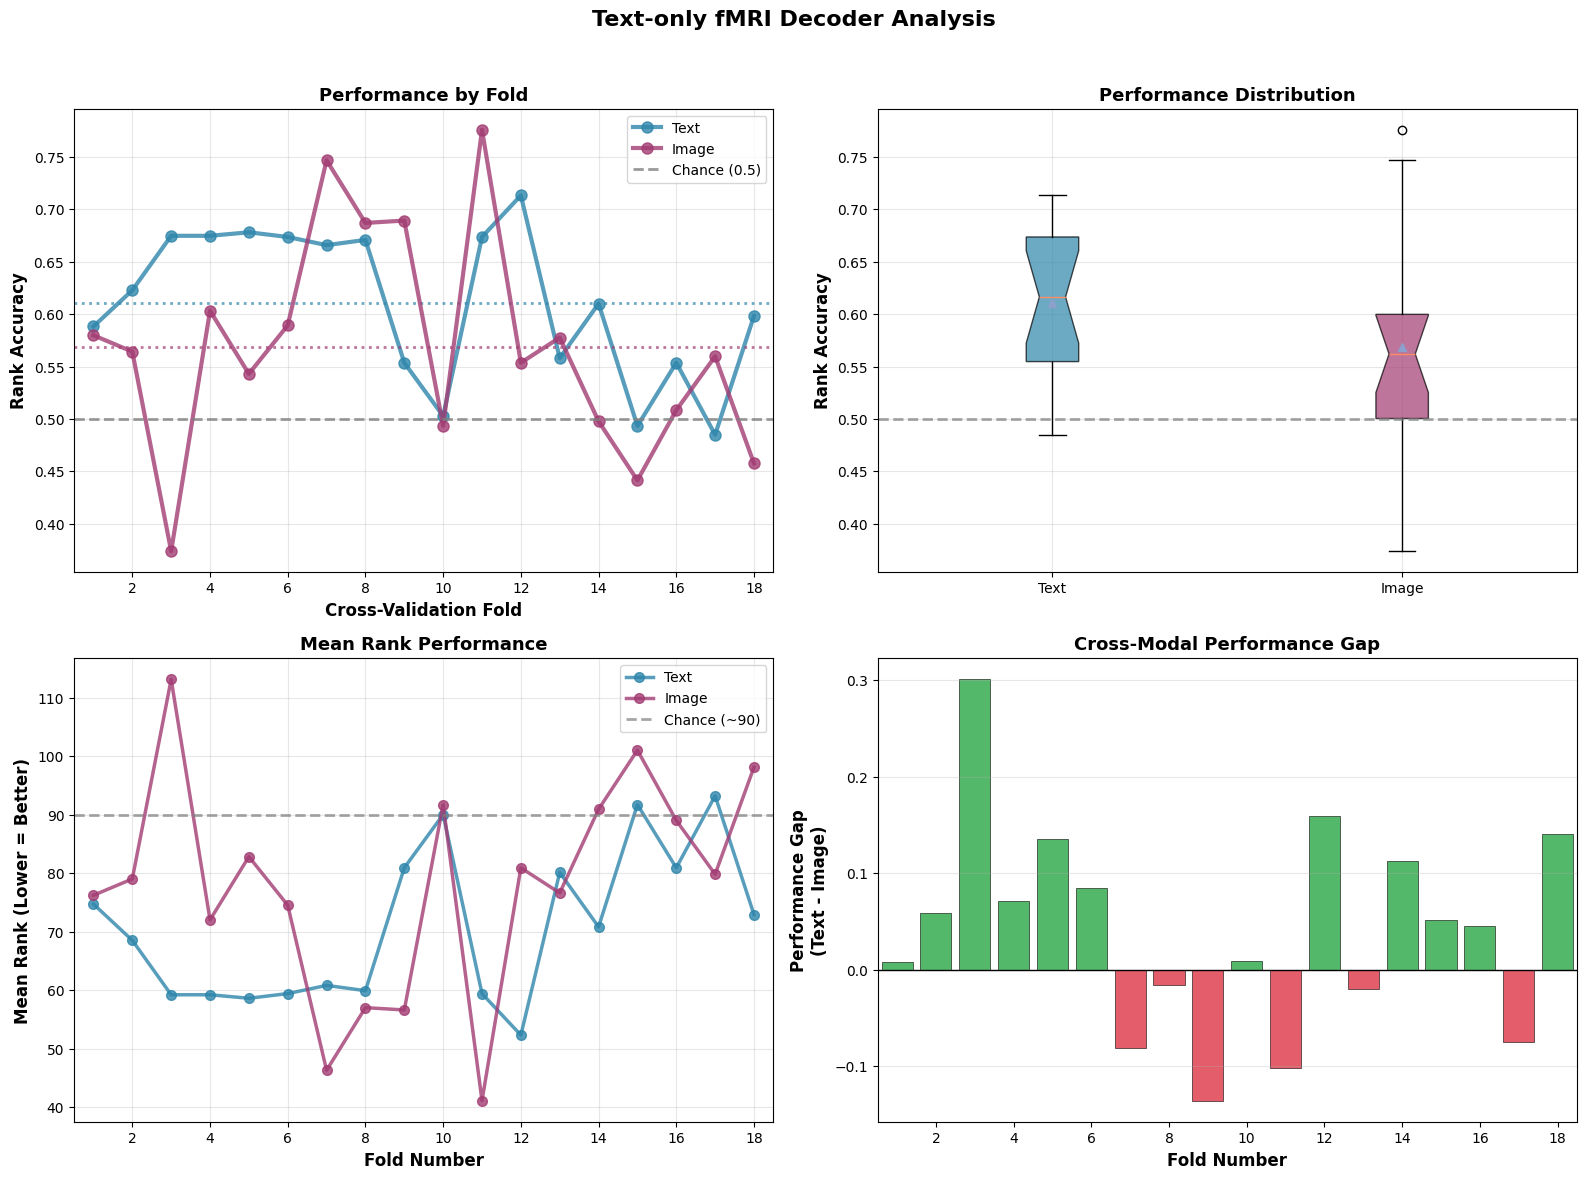


TEXT-ONLY FMRI DECODER ANALYSIS SUMMARY

TEXT EVALUATION:
  Mean Accuracy:     0.6106 ± 0.0704
  95% Confidence:    [0.5746, 0.6467]
  Range:             [0.4849, 0.7134]
  Mean Rank:         70.7 ± 12.6
  Improvement:       +22.1% over chance
  Statistical Test:  t(17) = 6.477, p = 5.69e-06
  Effect Size:       Cohen's d = 1.571

IMAGE EVALUATION:
  Mean Accuracy:     0.5690 ± 0.1019
  95% Confidence:    [0.5169, 0.6212]
  Range:             [0.3737, 0.7760]
  Mean Rank:         78.1 ± 18.2
  Improvement:       +13.8% over chance
  Statistical Test:  t(17) = 2.792, p = 1.25e-02
  Effect Size:       Cohen's d = 0.677


In [108]:
analysis_text = DecVTC_pipeline(
    text_embeddings=text_embeddings,
    img_embeddings=img_embeddings,
    img_concepts=img_concepts,
    concepts=concepts,
    fmri_text=fmri_text_data,
    grouping_method="mean",
    learn_decoder_fn=learn_decoder,
    mask_fn=mask_fmri_voxels_faster,
    k=3
)

## Multi-modal to CLIP


In [95]:
import scipy.io

# Define constants
FMRI_IMAGE_PATH = "data/brain-responses-data/examples_180concepts_pictures.mat"

# Get the fMRI data, specifically for image fmri
image_mat = scipy.io.loadmat(FMRI_IMAGE_PATH)
fmri_image_data = image_mat["examples"]

In [ ]:
import numpy as np

def multimodal_mask_indices(modalities, num_voxels=5000):
    """
    Take the union of top-k voxel indices from multiple modalities.

    Args:
        modalities: list of dicts, each with:
            {
              "fmri": (N,V) array,
              "sem":  (N,D) array or (N,)
            }
        num_voxels: how many voxels to keep per modality before union.

    Returns:
        np.ndarray[int]: sorted unique voxel indices in the union.
    """
    all_indices = set()
    for m in modalities:
        idx = mask_fmri_voxels(m["fmri"], m["sem"], num_voxels)
        all_indices.update(idx)
    return np.array(sorted(all_indices), dtype=int)


In [ ]:
def create_multimodal_mask_fn(fmri_text, fmri_image, text_targets, image_targets, mask_size):
    """
    Create a masking function for multimodal data that can be used in cross-validation.
    
    Args:
        fmri_text: (N, V) text fMRI data
        fmri_image: (N, V) image fMRI data  
        text_targets: (C, D) text embeddings
        image_targets: (C, D) image embeddings
        mask_size: number of voxels to select
    
    Returns:
        A function that takes (train_X, train_Y, num_voxels) and returns voxel indices
    """
    def multimodal_mask_fn(train_X, train_Y, num_voxels=mask_size):
        # Split the training data back into text and image portions
        n_text = len(fmri_text)
        train_text_X = train_X[:n_text] if train_X.shape[0] > n_text else train_X
        train_img_X = train_X[n_text:] if train_X.shape[0] > n_text else np.array([]).reshape(0, train_X.shape[1])
        
        # Split the training targets back into text and image portions
        train_text_Y = train_Y[:n_text] if train_Y.shape[0] > n_text else train_Y
        train_img_Y = train_Y[n_text:] if train_Y.shape[0] > n_text else np.array([]).reshape(0, train_Y.shape[1])
        
        # Only use multimodal masking if we have both modalities in training
        if len(train_img_X) > 0:
            return multimodal_mask_indices(
                [
                    {"fmri": train_text_X, "sem": train_text_Y},  # Use actual training targets
                    {"fmri": train_img_X, "sem": train_img_Y}     # Use actual training targets
                ],
                num_voxels=num_voxels
            )
        else:
            # Fallback to single-modality masking
            return mask_fmri_voxels(train_text_X, train_text_Y, num_voxels)  # Use actual training targets
    
    return multimodal_mask_fn

Cross-validation folds: 100%|██████████| 18/18 [08:02<00:00, 26.80s/it]
C:\Users\user\AppData\Local\Temp\ipykernel_27644\1222916205.py:333: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax2.boxplot(box_data, labels=[et.title() for et in eval_types], patch_artist=True,


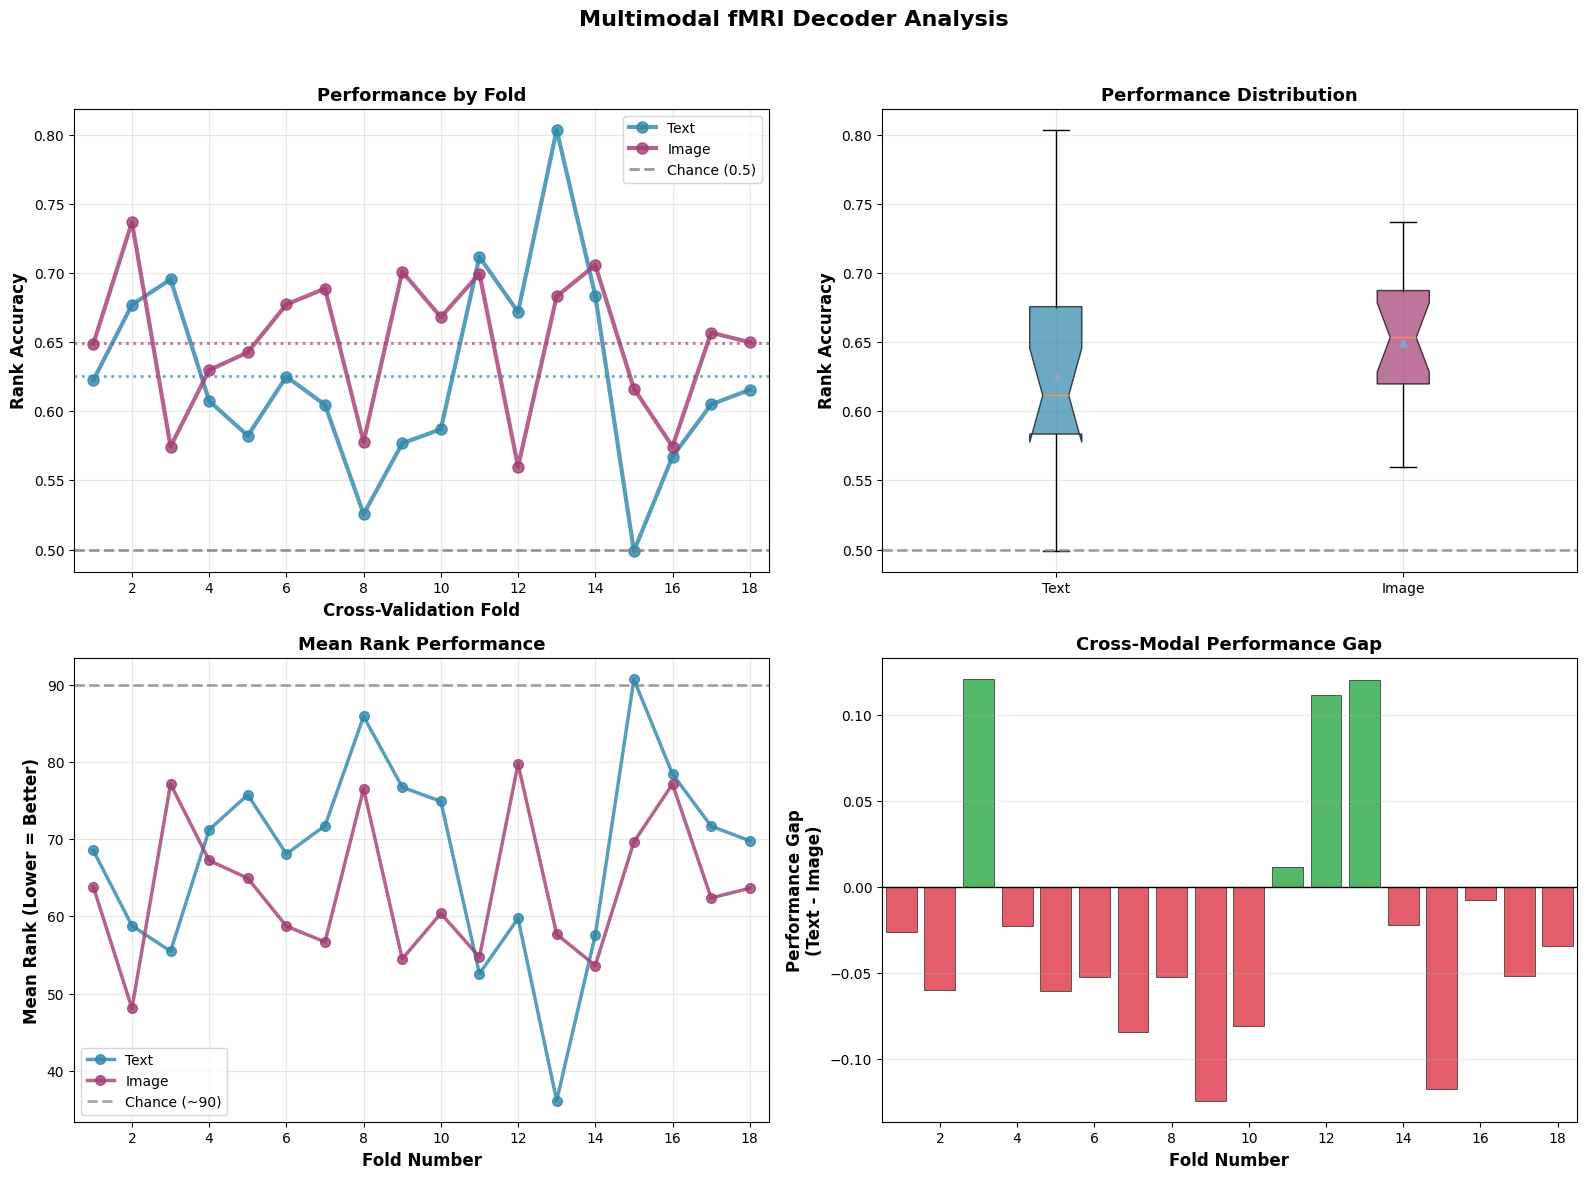


MULTIMODAL FMRI DECODER ANALYSIS SUMMARY

TEXT EVALUATION:
  Mean Accuracy:     0.6257 ± 0.0702
  95% Confidence:    [0.5898, 0.6616]
  Range:             [0.4989, 0.8036]
  Mean Rank:         68.0 ± 12.6
  Improvement:       +25.1% over chance
  Statistical Test:  t(17) = 7.386, p = 1.06e-06
  Effect Size:       Cohen's d = 1.791

IMAGE EVALUATION:
  Mean Accuracy:     0.6496 ± 0.0504
  95% Confidence:    [0.6238, 0.6754]
  Range:             [0.5601, 0.7369]
  Mean Rank:         63.7 ± 9.0
  Improvement:       +29.9% over chance
  Statistical Test:  t(17) = 12.239, p = 7.43e-10
  Effect Size:       Cohen's d = 2.968


In [ ]:
analysis_multi_modal = DecVTC_pipeline (
    text_embeddings=text_embeddings,
    img_embeddings=img_embeddings,
    img_concepts=img_concepts,
    concepts=concepts,
    fmri_text=fmri_text_data,
    grouping_method="mean",
    learn_decoder_fn=learn_decoder,
    mask_fn=mask_fmri_voxels,
    create_multimodal_mask_fn=create_multimodal_mask_fn,
    fmri_image=fmri_image_data,
    multimodal=True,
    k=3
)

## Model Comparison


COMPARING MULTIMODAL VS TEXT-ONLY:


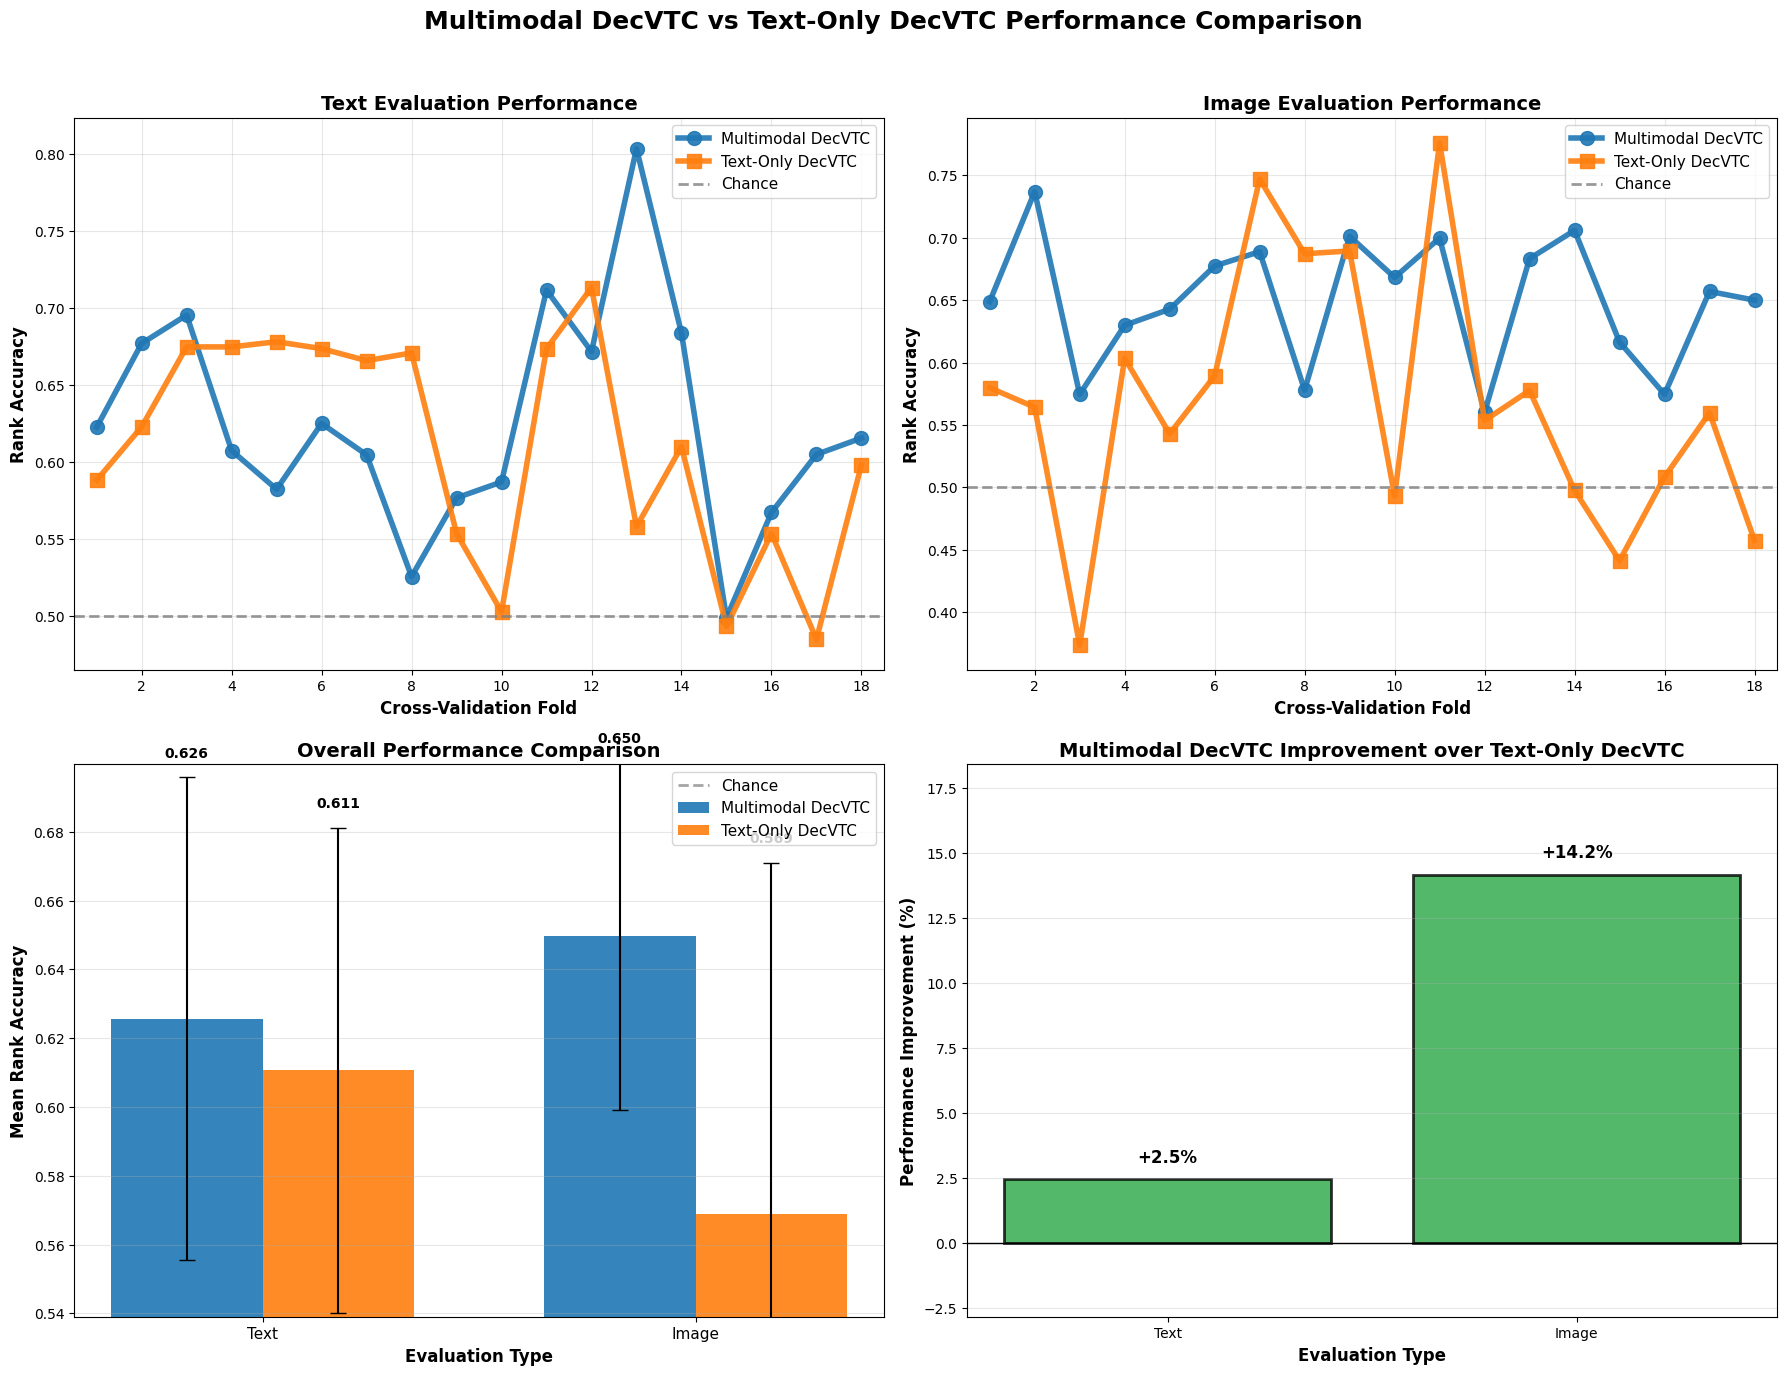

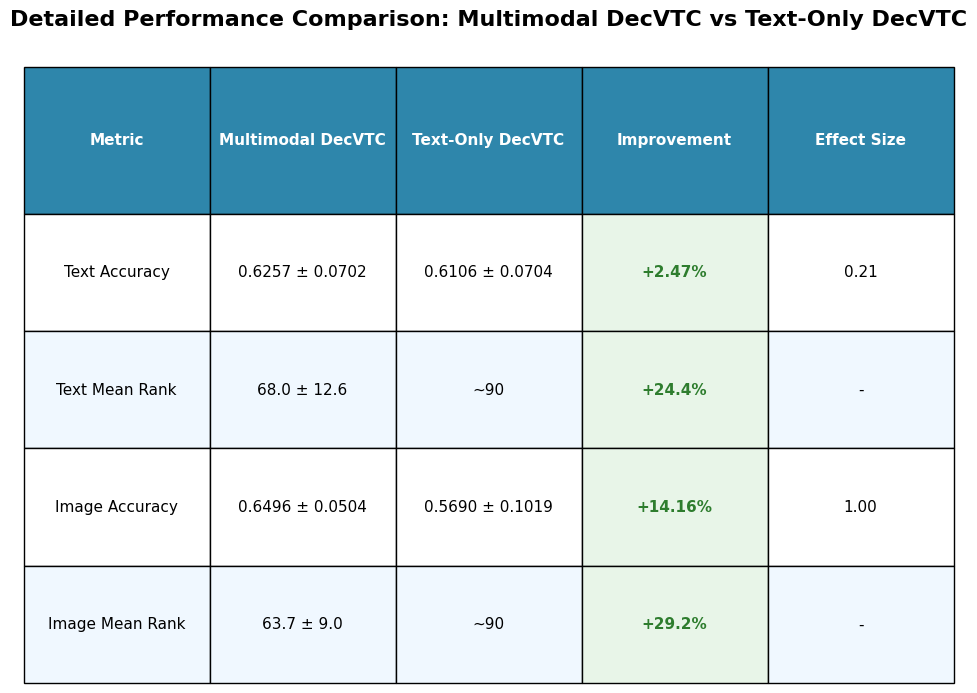


MULTIMODAL DECVTC VS TEXT-ONLY DECVTC COMPARISON

TEXT EVALUATION:
  Multimodal DecVTC: 0.6257 ± 0.0702
  Text-Only DecVTC: 0.6106 ± 0.0704
  Improvement: +2.47%

IMAGE EVALUATION:
  Multimodal DecVTC: 0.6496 ± 0.0504
  Text-Only DecVTC: 0.5690 ± 0.1019
  Improvement: +14.16%


In [106]:
# Compare multimodal vs text-only
print("\nCOMPARING MULTIMODAL VS TEXT-ONLY:")
comparison_analysis = analyze_fmri_model(
    results_multi_modal, 
    model_name="Multimodal DecVTC",
    comparison_results=results_text,
    comparison_name="Text-Only DecVTC"
)